In [15]:
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(data.table))
suppressPackageStartupMessages(require(ggpubr))
suppressPackageStartupMessages(require(tidyverse))
suppressPackageStartupMessages(require(ggtext))
library(glue)

options(warn = -1)

**Parameters**

In [ ]:
# Inputs
workDir <- "Inflammation-PBMCs-Atlas/"
scCODADir <- paste0(workDir, "/03_downstream_analysis/01_compositional_analysis/scCODA/")
comparisonDir <- paste0(scCODADir,"/comparisons")
formula_parameter <- "C(disease, Treatment('healthy')) + C(sex) + C(binned_age)"

# Palette
color_palette_path <- paste0(scCODADir, "colors_palette.R")
source(color_palette_path)

# Diseases 
diseases = names(disease_colors)
celltypes = names(cell_colors)

# Outputs
outputpath <- paste0(scCODADir, "results/")

# Load data

In [ ]:
counts_df <- map(diseases, function(disease) {
  if (disease != "healthy") {
        file_path <- file.path(comparisonDir, disease, paste0(disease, "_counts.csv"))
        df <- read_csv(file_path, show_col_types = FALSE)
        df <- column_to_rownames(df, var = colnames(df)[1])
        df <- df[,2:16]
    return(df)
  }
  return(NULL)
}) %>%
  set_names(diseases)

# Filter out NULL values (in case of 'healthy')
counts_df <- counts_df[!sapply(counts_df, is.null)]

In [4]:
formula_parameter <- "C(disease, Treatment('healthy')) + C(sex) + C(binned_age)"
scCODA_df <- map(diseases, function(disease) {
  if (disease != "healthy") {
    file_path <- file.path(comparisonDir, disease, paste0(disease, "_all_results_", formula_parameter, "_DC.csv"))
    df <- read_csv(file_path, show_col_types = FALSE)
    df_comparison <- df[1:13,]
    df_comparison$CellType <- df_comparison$`Cell Type`
    df_comparison$log2FC <- df_comparison$`log2-fold change`
    #df_comparison <- column_to_rownames(df, var = colnames(df)[2])
    return(df_comparison)
  }
  return(NULL)
}) %>%
  set_names(diseases)

# Filter out NULL values (in case of 'healthy')
scCODA_df <- scCODA_df[!sapply(scCODA_df, is.null)]

# Define reference celltype

## Dispersion vs presence

In [5]:
library(ggplot2)
library(dplyr)

rel_abundance_dispersion_plot <- function(
  data,
  abundant_threshold = 0.9,
  default_color = "lightgrey",
  abundant_color = "red",
  label_cell_types = TRUE,
  figsize = c(10, 8),
  title = "",
  dpi = 100
) {
  # Calculate relative abundance
  rel_abun <- data / rowSums(data, na.rm = TRUE)
  
  # Calculate percent of zero counts for each cell type
  percent_zero <- colSums(data == 0) / nrow(data)
  nonrare_ct <- which(percent_zero < 1 - abundant_threshold)
  
  # Calculate dispersion
  cell_type_disp <- apply(rel_abun, 2, var, na.rm = TRUE) / colMeans(rel_abun, na.rm = TRUE)
  
  # Identify abundant cell types
  is_abundant <- colnames(data) %in% colnames(data)[nonrare_ct]
  
  # Create data frame for plotting
  plot_df <- data.frame(
    `Total_dispersion` = cell_type_disp,
    `Cell_type` = colnames(data),
    `Presence` = 1 - percent_zero,
    `Is_abundant` = is_abundant
  )
  
  # Define color palette
  plot_df$color <- ifelse(plot_df$Is_abundant, abundant_color, default_color)
  
  # Plot
  p <- ggplot(plot_df, aes(x = Presence, y = Total_dispersion, color = Is_abundant)) +
    geom_point(size = 1.5) +
    scale_color_manual(values = c("TRUE" = abundant_color, "FALSE" = default_color)) +
    theme_minimal() +
    labs(
      x = "Presence",
      y = "Total Dispersion",
      title = title,
      color = "Is abundant"
    ) +
    theme(
      plot.title = element_text(hjust = 0.5),
      legend.position = "none"
    ) + theme(
            axis.text.x = element_text(angle = 45, hjust = 1),
            panel.grid = element_blank(), 
            panel.border = element_rect(color = "black", fill = NA, size = 1))
  
  # Add text labels for abundant cell types if requested
  if (label_cell_types) {
    abundant_df <- plot_df %>% filter(Is_abundant)
    p <- p + geom_text(
      data = abundant_df, 
      size = 3,
      aes(label = Cell_type),
      nudge_x = -0.025,
      hjust = 0, 
        color = "black"
    )
  }
  
  #print(p)
  return(p)
}

In [6]:
plots <- map(diseases, function(disease) {
  if (disease != "healthy") {
    data <- counts_df[[disease]]
    data <- data %>%
      select(-sampleID, -disease)
    plot <- rel_abundance_dispersion_plot(data, title=disease, abundant_threshold=0.95)  
    return(plot)
  }
  return(NULL)
}) %>%
  set_names(diseases)
plots <- plots[!sapply(plots, is.null)]

In [7]:
library(patchwork)

# Flatten the list of plots with placeholders for blank spaces
combined_plot <- wrap_plots(
  plots[[1]], plots[[2]], plots[[3]], plots[[4]], 
  plots[[5]], plots[[6]], plots[[7]], plot_spacer(),
  plots[[8]], plots[[9]], plots[[10]], plot_spacer(),
  plots[[11]], plot_spacer(), plot_spacer(), plot_spacer(),
  plots[[12]], plots[[13]], plots[[14]], plots[[15]],
  plots[[16]], plots[[17]], plots[[18]], plots[[19]],
  ncol = 4, 
  nrow = 6  
)

# Save the combined plot to a PDF
ggsave(
  filename = paste0(outputpath, "disp_vs_presence.pdf"),
  plot = combined_plot,
  device = "pdf",
  width = 20,   
  height = 20   
)

In [11]:
options(repr.plot.width = 20, repr.plot.height = 20)


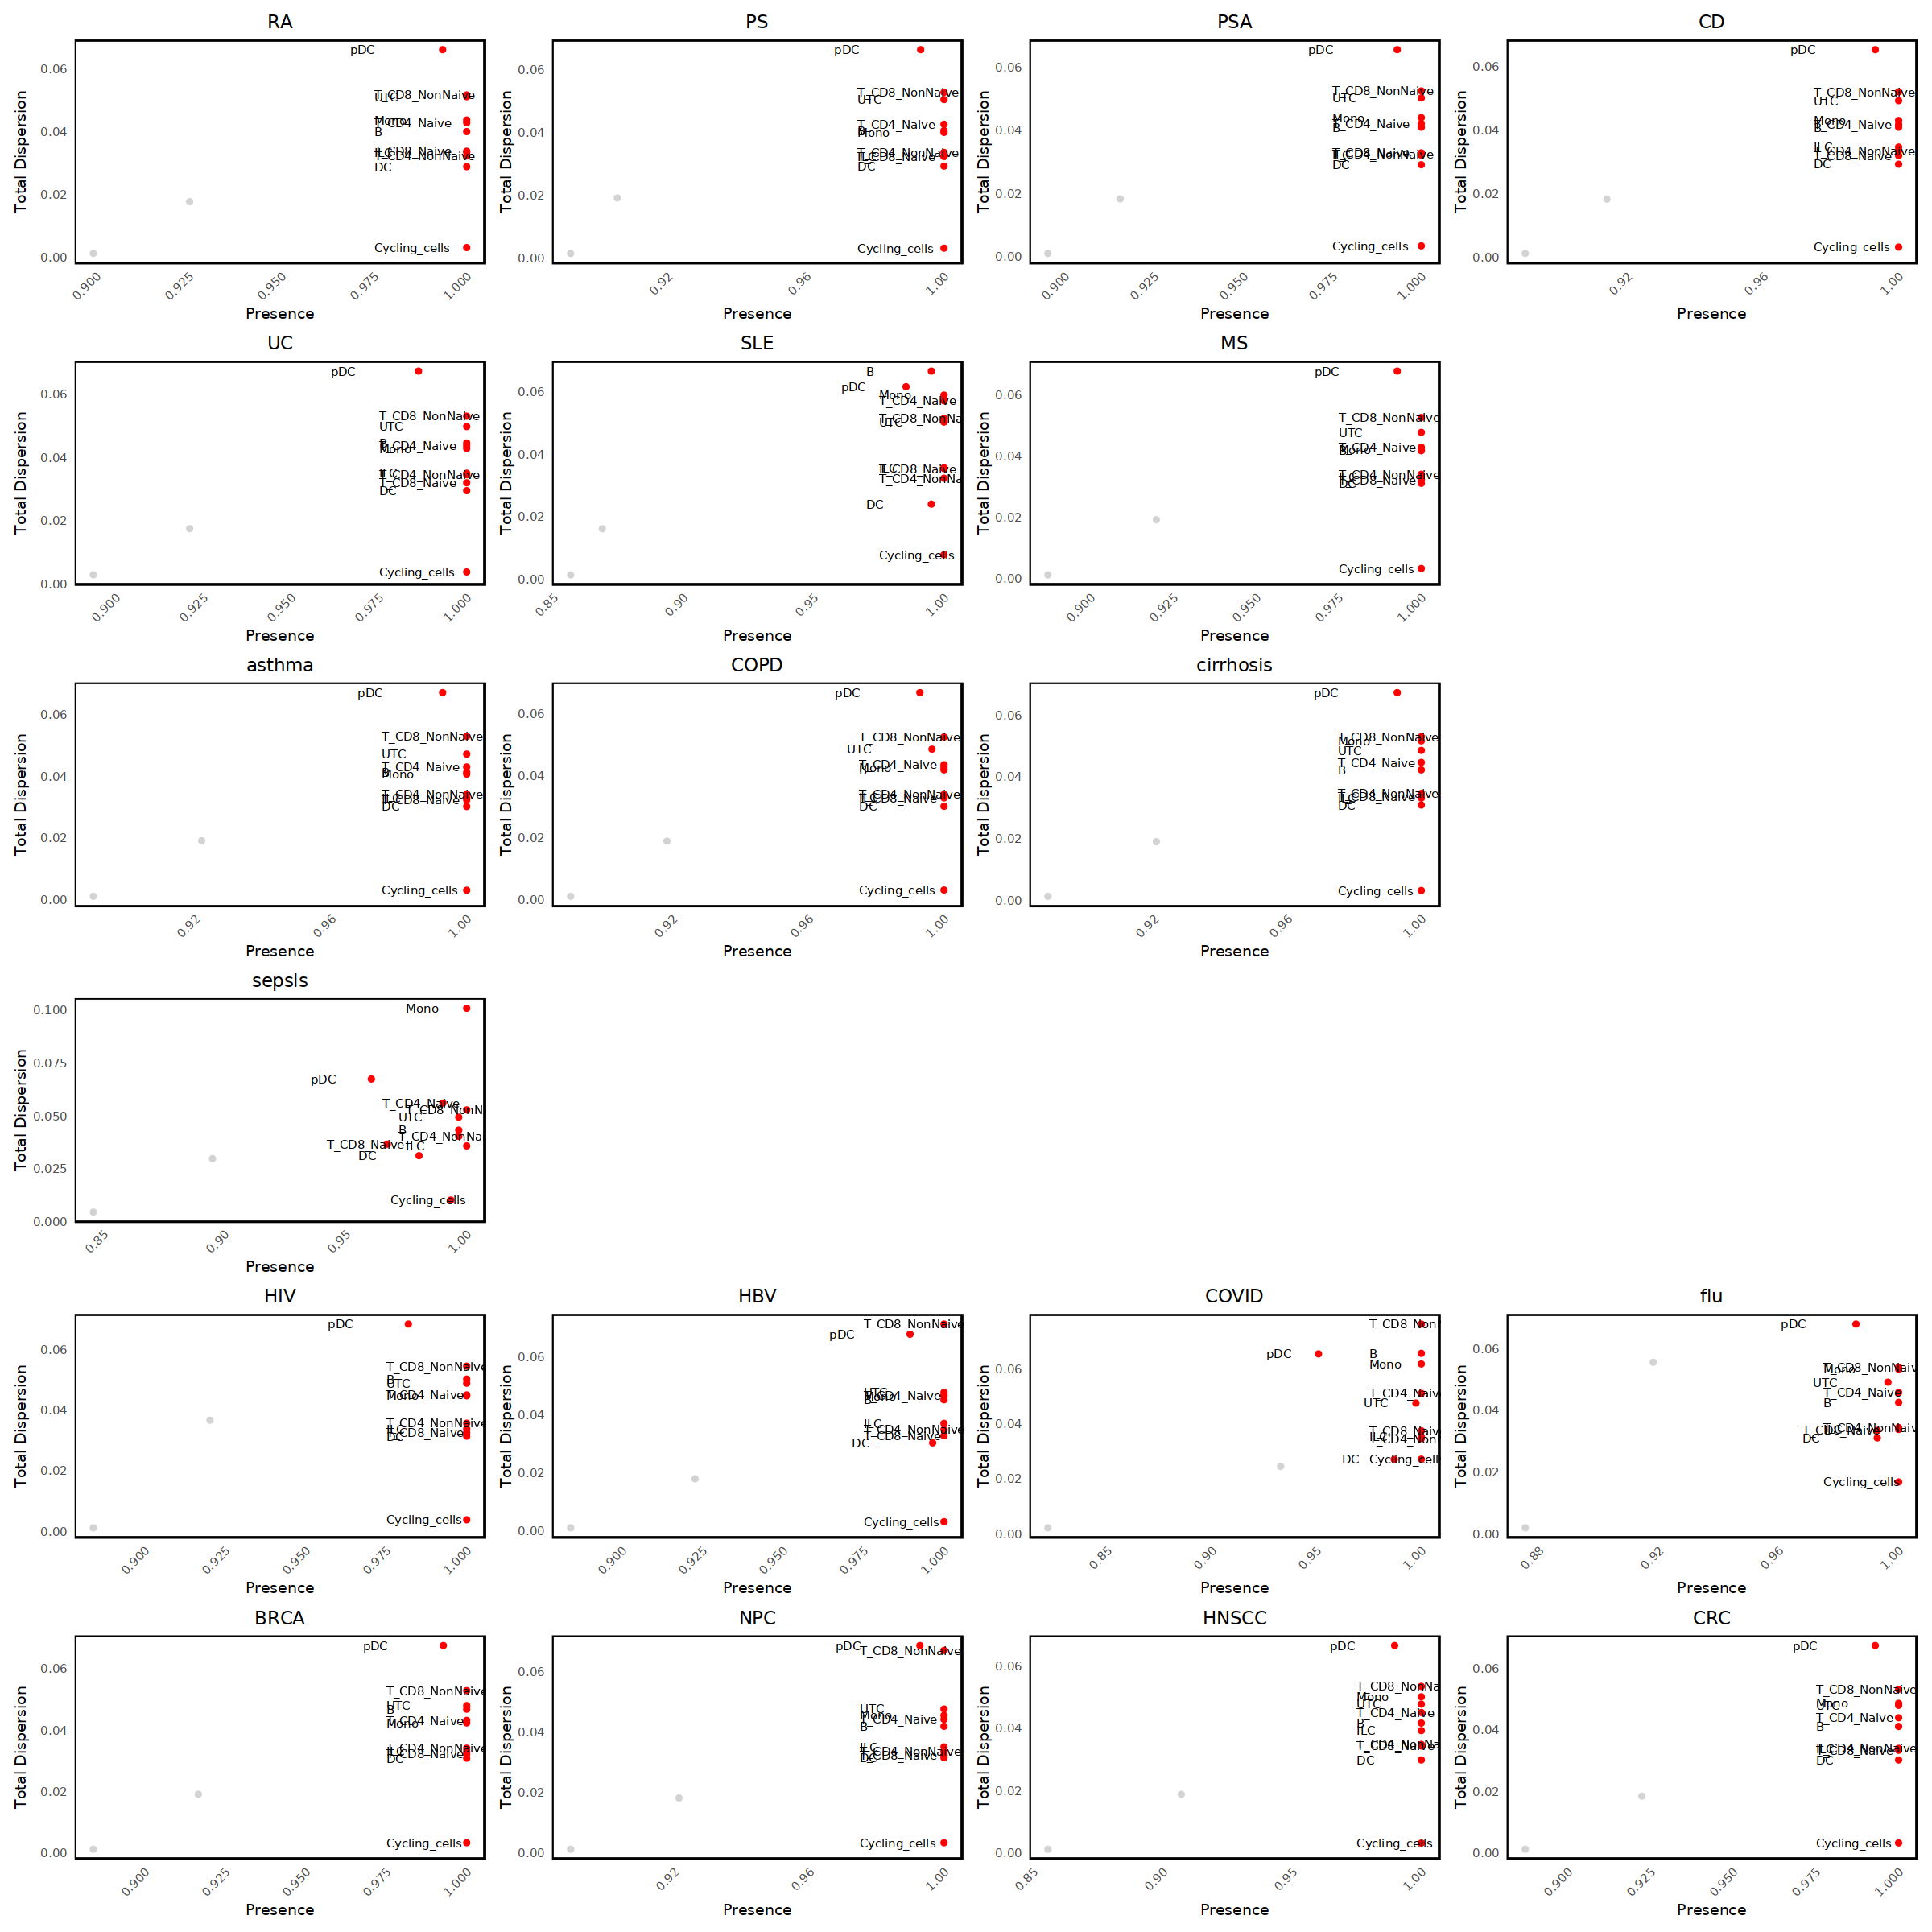

In [12]:
combined_plot

# scCODA results

## Reference celltypes

## Process dfs

In [13]:
log2_threshold = 0.5

In [16]:
toplot_dfs <- map(diseases, function(disease) {
  if (disease != "healthy") {
    df <- scCODA_df[[disease]]
    reference_celltype = "DC"
    df_toplot <- df %>%
      mutate(color = ifelse(`Final Parameter` != 0 & abs(`log2-fold change`) >= log2_threshold, 
                        cell_colors[as.character(`Cell Type`)], 
                        "lightgrey"))
    df_toplot$CellType <- df_toplot$`Cell Type`
    df_toplot <- df_toplot %>%
      mutate(
    BoldLabel = CellType == reference_celltype,
    StyledClass = if_else(BoldLabel, glue("<b>{CellType}</b>"), glue("<i>{CellType}</i>")))
    df_toplot$StyledClass <- factor(df_toplot$StyledClass, levels = unique(df_toplot$StyledClass))
    return(df_toplot)
  }
  return(NULL)
}) %>%
  set_names(diseases)
toplot_dfs <- toplot_dfs[!sapply(toplot_dfs, is.null)]

## DotPlot

In [17]:
library(tidyverse)
library(RColorBrewer)

In [18]:
toplot_dfs <- map(diseases, function(disease) {
  if (disease != "healthy") {
    df <- scCODA_df[[disease]]
    df$CellType <- df$`Cell Type`
    df$log2FC <- df$`log2-fold change`
    df$credible <- df$`Final Parameter` != 0
    df_subset <- df[c("CellType", "log2FC", "credible")]
    return(df_subset)
  }
  return(NULL)
}) %>%
  set_names(diseases)
toplot_dfs <- toplot_dfs[!sapply(toplot_dfs, is.null)]

In [20]:
combined_df <- bind_rows(toplot_dfs, .id = "disease")
combined_df$CellType <- factor(combined_df$CellType, levels = rev(celltypes))
combined_df$disease <- factor(combined_df$disease, levels = diseases)

In [44]:
gg_dotplot_effect_glob <- combined_df %>%
    ggplot(aes(
      x = disease, 
      y = CellType,
      color = log2FC, 
      size = credible)) + 
    geom_point() + 
    scale_color_gradient2(low="#0000FF", mid="#FFFFFF", high="#FF0000", midpoint=0) + # , limits = c(-1,1),
    cowplot::theme_cowplot() + 
    labs(title = "",
         color = "Log2FC",
         size = "Credible effects") + 
    theme(axis.ticks = element_blank(),
          axis.title = element_blank(),
          axis.line  = element_blank(),
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          legend.position = "bottom",
          legend.text = element_text(size=10))

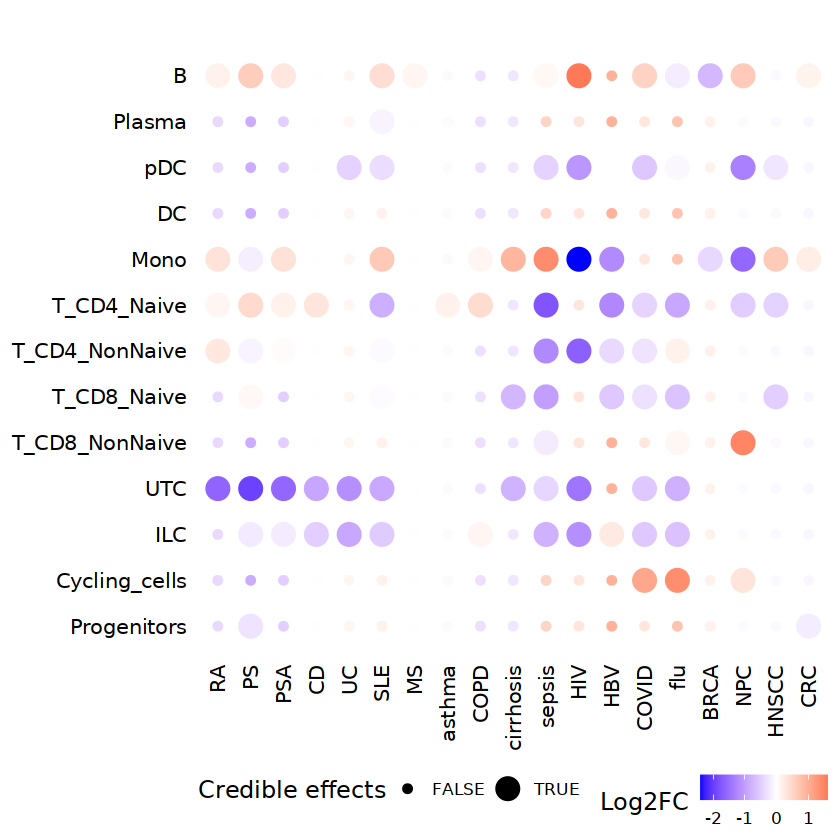

In [45]:
gg_dotplot_effect_glob

In [46]:
ggsave(
  filename = paste0(outputpath, "disease_scCODA_dotPlot_ref_DC.pdf"),
  plot = gg_dotplot_effect_glob,
  device = "pdf",
  width = 10,   # Adjust the width as needed
  height = 7   # Adjust the height as needed
)